# This notebook includes a simple demo for flood risk assessment

## It uses flood hazard water depth scenario RP100 and population map for 2018

In [2]:
# Added to requirements.txt, but need to specify version? Then remove here
#!pip -q install geopandas
#!apt -q install libspatialindex-dev
#!pip -q install osmnx
#!pip -q install rasterio
#!pip -q install rasterstats
#!pip -q install geojson

### Import required libraries

In [3]:
# Required libraries
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats, utils
import rasterio.mask
import gdal, gdalconst
from osgeo import ogr, osr
from shapely import wkb
from matplotlib import pyplot
from shapely.geometry import shape

ModuleNotFoundError: No module named 'gdal'

In [ ]:
# All prev bunch (not all required)

import seaborn as sns
import geojson
import json
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape, box, mapping, Point, Polygon
import numpy as np
import osmnx as ox
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
import math
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats, utils
import gdal, gdalconst
import ee
from osgeo import ogr, osr
from shapely import wkb
import rasterio.mask
from matplotlib import pyplot
from shapely.geometry import shape

Do we need this class stuff?

In [ ]:
#class to work with tiff datasets
class Raster:
    
    def __init__(self, filename):
        self.filename = filename
    #get data using bounding box
    def dataFromBounds(self, band, bounds):
        with rasterio.open(self.filename) as src:
            self.noData = src.nodatavals[0]
            window = rasterio.windows.from_bounds(bounds[0],bounds[1],bounds[2],bounds[3], src.transform)
            self.boundsData = src.read(band, window=window)
            self.boundsTransform = src.window_transform(window)
    #get data using polygon for masking
    def dataFromShape(self,band,shape):
        with rasterio.open(self.filename) as src:
            self.noData = src.nodatavals[0]
            self.maskData, self.maskTransform = rasterio.mask.mask(src, [shape], crop=True, nodata=0)
            self.maskData = self.maskData[band-1, :, :]


### Load input data: flood hazard (RP100) and population (Landscan 2018)

In [ ]:
#fd represents the flood raster
fd = Raster('/data/ssudan/hzd-ss-fl-rp100.tif')

#pop represents population data
pop = Raster('/data/ssudan/exp-ss-pop-landscan18.tif')

#adm2 represents administrative units
adm0 = ogr.Open('/data/ssudan/SS_ADM0.shp')
adm1 = ogr.Open('/data/ssudan/SS_ADM1.shp')
adm2 = ogr.Open('/data/ssudan/SS_ADM2.shp')

#print attributes in shapefile to help grab what's needed in SetAttributeFilter
print([defn.GetFieldDefn(i).GetName() for i in range(defn.GetFieldCount())])

### Create flood hazard extent mask using a threshold of 5 cm

In [ ]:
fd_mask = turn into boolean mask

### Estimate population within hazard extent and plot as map

In [ ]:
pop_fd = fd_max * pop

plot over osm basemap


### Summary for ADM2 level - zonal statistics

In [ ]:
zonalStatsFB = zonal_stats(geometries, pop.maskData, affine = pop.maskTransform, stats=['sum'], nodata=pop.noData)

plot = results shown as map and as table

### Export data

In [ ]:
Export table as csv

Original code below as reference, to be deleted

In [ ]:
#load shapefile for masking
#shapeFile represents the administrative zones you want to focus on
shapeFile = ogr.Open('/data/ssudan/SS_ADM2.shp')
shapes = shapeFile.GetLayer(0)
defn = shapes.GetLayerDefn()
#print attributes in shapefile to help grab what's needed in SetAttributeFilter
print([defn.GetFieldDefn(i).GetName() for i in range(defn.GetFieldCount())])

['ADM2_CODE', 'ADM2_NAME', 'STR2_YEAR', 'EXP2_YEAR', 'ADM1_CODE', 'ADM1_NAME', 'STATUS', 'DISP_AREA', 'ADM0_CODE', 'ADM0_NAME', 'Shape_Leng', 'Shape_Area']


In [ ]:
#this piece selects a specific admin 2 area by default. 
#you can set it for any field printed above from the shape and then even value you expect in the shapefile
shapes.SetAttributeFilter("GID_2 = 'SLE.4.2_1'")
#admin unit we want as geom instance
filtered = shapes.GetNextFeature()
geom = filtered.GetGeometryRef()
#admin unit we want as shapely polygon
filterPoly = wkb.loads(geom.ExportToWkb())
#bounding box (unused)
#bbox = geom.GetEnvelope()

In [ ]:
#if you wanted to use the bounding box to mask the raster, this line would do it
#fd.dataFromBounds(1, [bbox[0], bbox[2], bbox[1], bbox[3]])

#set raster data based on masking poly filterPoly
fd.dataFromShape(1,filterPoly)

#set population data based on masking poly
pop.dataFromShape(1,filterPoly)
print(np.min(popFB.maskData))

0.0


9067


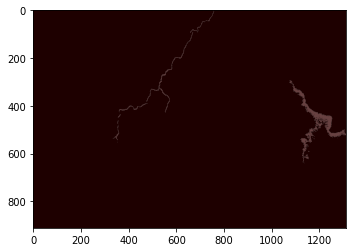

In [ ]:
#bounding box line
#polyArray = (np.logical_and(fd.boundsData>0, fd.boundsData<999))

#using masked data
polyArray = (np.logical_and(fd.maskData>0, fd.maskData<999))
pyplot.imshow(polyArray, cmap='pink', vmin=0, vmax=10)

geometries = []
#convert raster to polygon shapes for intersection calculations
for vec in rasterio.features.shapes(fd.maskData,mask=(np.logical_and(fd.maskData>0, fd.maskData<999)),transform=fd.maskTransform):
  geometries.append(shape(vec[0]))

#number of flood polygons for intersecting
print(len(geometries))

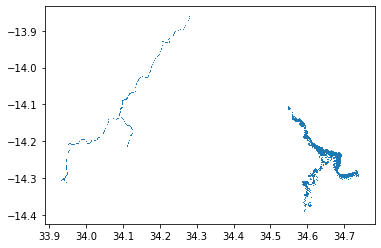

In [ ]:
#create GeoDataFrame from flood polygons and plot to see what we're dealing with
gdf = gpd.GeoDataFrame({
    'geometry':geometries
})
gdf.plot()

In [ ]:
#read buildings into memory for faster processing
#buildingShapefile represents the building shapefile for intersections. it can be any building layer
buildingShapeFile = ogr.Open('/content/Fathom/MWI_buildings_exposure_20171213.shp')
outDriver = ogr.GetDriverByName('MEMORY')
source = outDriver.CreateDataSource('memData')

tmp = outDriver.Open('memData', 1)
pipesMem = source.CopyLayer(buildingShapeFile.GetLayer(0), 'buildings', ['OVERWRITE=YES'])

In [ ]:
buildingLayer = source.GetLayer('buildings')

proj = buildingLayer.GetSpatialRef()
srid = int(proj.GetAttrValue('AUTHORITY', 1))

#define coordinate transformation
inSpatialRef = osr.SpatialReference()
inSpatialRef.ImportFromEPSG(srid)

#assuming rasters and shapefile in 4326, may not be
outSpatialRef = osr.SpatialReference()
outSpatialRef.ImportFromEPSG(4326)

coordTrans = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)
coordTransInv = osr.CoordinateTransformation(outSpatialRef, inSpatialRef)


filterGeom = filtered.GetGeometryRef()
filterGeom.Transform(coordTransInv)

#filter buildings by admin unit polygon
buildingLayer.SetSpatialFilter(filterGeom)

count = 0
buildingGeometries = []

for i in range(buildingLayer.GetFeatureCount()):
  feature = buildingLayer.GetNextFeature()
  geom=feature.GetGeometryRef()
  #add valid buildings to buildingGeometries list
  if (not geom is None):
    geom.Transform(coordTrans)
    if (geom.IsValid()):
      count = count+1
      buildingGeometries.append(geom.ExportToWkb())
print(count)

3828


In [ ]:
#create building GeoDataFrame
df = pd.DataFrame({
    'Coordinates':buildingGeometries
})
df['Coordinates'] = df['Coordinates'].apply(wkb.loads)
buildingGdf = gpd.GeoDataFrame(df, geometry='Coordinates')

In [ ]:
#create spatial index
sindex = buildingGdf.sindex

In [ ]:
#return number of buildings intersecting a polygon
def returnNumIntersect(spatialIndex, buildingDF, clippingPoly):
    possible_matches_index = list(spatialIndex.intersection(clippingPoly.bounds))
    possible_matches = buildingDF.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(clippingPoly)]
    if (precise_matches.empty):
        return 0
    return len(precise_matches.index)

In [ ]:
#Calculate total buildings in floodplain
totalBuildings = 0
for i, geom in enumerate(geometries):
  totalBuildings = totalBuildings + returnNumIntersect(sindex,buildingGdf, geom)
print(totalBuildings)

77


In [ ]:
#calculate zonal statistics
zonalStatsFB = zonal_stats(geometries, pop.maskData, affine = pop.maskTransform, stats=['sum'], nodata=pop.noData)

In [ ]:
#print total population affected
totalPop = 0
for el in zonalStatsFB:
  if not el['sum'] is None:
    totalPop = totalPop + el['sum']

print(totalPop)

12052.5401506513
